In [1]:
%%time
import bayes3d as b
import jax.numpy as jnp
import jax
import numpy as np
from tqdm import tqdm
import bayes3d.o3d_viz
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
CPU times: user 5.39 s, sys: 1.3 s, total: 6.69 s
Wall time: 5.3 s


In [7]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=5.0
)

renderer = b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [49]:
contact_plane = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

grid_params = [
    (0.3, jnp.pi, (11,11,11)), (0.1, jnp.pi/3, (11,11,11)), (0.05, jnp.pi/5, (11,11,1)),
    (0.05, jnp.pi/5, (11,11,11))
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

key = jax.random.PRNGKey(100)

2.158894
5.0


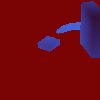

In [50]:
key = jax.random.split(key)[1]
indices = jax.random.choice(key,21,shape=(3,))
contact_params = jax.random.uniform(
    key,
    shape=(3,3,),
    minval=jnp.array([-0.2,-0.2, 0.0]),
    maxval=jnp.array([0.2, 0.2, 2*jnp.pi])
)
faces = jnp.array([3,3,3])
dims_child = b.RENDERER.model_box_dims[indices]
poses_ground_truth = contact_plane @ b.scene_graph.relative_pose_from_edge_parallel_jit(
    contact_params, faces, dims_child
)
observed_point_cloud_image = b.RENDERER.render_multiobject(poses_ground_truth, indices)[...,:3]
print(jnp.min(observed_point_cloud_image[:,:,2]))
print(jnp.max(observed_point_cloud_image[:,:,2]))
b.get_depth_image(observed_point_cloud_image[:,:,2])

In [51]:


VARIANCE_GRID = jnp.array([ 0.00001, 0.0001, 0.001])
OUTLIER_GRID = jnp.array([0.1, 0.01, 0.001])
OUTLIER_VOLUME = 100.0

gt_trace = b.Trace(
    poses_ground_truth , indices, VARIANCE_GRID[0], OUTLIER_GRID[0], OUTLIER_VOLUME,
    observed_point_cloud_image
)
print(b.score_trace(gt_trace))

trace = b.Trace(
    jnp.zeros((0,4,4)), jnp.array([],dtype=jnp.int32),
    VARIANCE_GRID[0], OUTLIER_GRID[0], OUTLIER_VOLUME,
    observed_point_cloud_image
)
b.viz_trace_meshcat(trace)

53051.547


In [52]:
%%time
traces = None
for _ in range(3):
    all_paths = []
    for obj_id in tqdm(range(len(b.RENDERER.meshes))):
        contact_param = jnp.zeros(3)
        p = None
        trace_path = []
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            contact_param, traces, trace_ = b.c2f.c2f_iter_trace_contact_params_jit(trace, contact_param, contact_param_gridding_schedule[c2f_iter], contact_plane, b.RENDERER.model_box_dims[obj_id], obj_id, 3, VARIANCE_GRID, OUTLIER_GRID)
            trace_path.append(trace_)

        all_paths.append(
            trace_path
        )
    scores = jnp.array([b.score_trace(t[-1]) for t in all_paths])
    print(scores)
    normalized_scores = b.utils.normalize_log_scores(scores)
    # print(["{:0.3f}".format(n) for n in normalized_scores])
    order = jnp.argsort(-scores)
    # print(order)
    new_trace = all_paths[jnp.argmax(scores)][-1]
    trace = new_trace
    b.viz_trace_meshcat(trace)


100%|██████████| 21/21 [00:05<00:00,  3.77it/s]


[39311.57  46598.82  41376.844 38387.68  40102.21  37665.617 36389.457
 38145.273 37785.586 37170.51  41185.934 41659.438 36800.742 38028.68
 37385.344 43234.07  36062.97  36112.977 36925.17  36418.055 37032.21 ]


100%|██████████| 21/21 [00:06<00:00,  3.32it/s]


[46598.82  46601.96  46598.82  46598.82  46598.82  49575.32  48147.336
 50084.312 46771.375 48925.69  46598.82  46598.82  46851.156 46989.312
 47302.633 46600.5   47870.484 47809.59  48784.023 48086.117 48132.61 ]


100%|██████████| 21/21 [00:07<00:00,  2.94it/s]


[50084.312 50087.453 50084.312 50084.312 50084.312 50889.4   50794.164
 51283.54  50278.336 52523.016 50084.312 50084.312 50358.113 50496.273
 50809.59  50085.992 50941.785 51443.562 51887.977 51978.453 50597.617]
CPU times: user 15.3 s, sys: 5.05 s, total: 20.3 s
Wall time: 20.1 s


In [39]:
b.score_traces(traces).shape

(51, 3, 3)